# Animal Detection Using ResNet18 with LoRA Fine-tuning

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

## Load Dataset

Source: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [2]:
# !rm -rf "/content/dataset/raw-img"
!unzip -q '/content/drive/MyDrive/datasets/animals10.zip' -d '/content/dataset/'

In [3]:
import os
import glob

translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider",

    # "dog": "cane",
    # "cavallo": "horse",
    # "elephant" : "elefante",
    # "butterfly": "farfalla",
    # "chicken": "gallina",
    # "cat": "gatto",
    # "cow": "mucca",
    # "spider": "ragno",
    # "squirrel": "scoiattolo"
}

for filename in glob.glob("/content/dataset/raw-img/**"):
    italian_name = filename.split("/")[4]
    try:
        english_name = translate[italian_name]
    except KeyError:
        translate_backwards = {v: k for k, v in translate.items()}
        english_name = translate_backwards[italian_name]
    new_filename = filename.replace(italian_name, english_name)
    os.rename(filename, new_filename)

In [7]:
data_dir = 'dataset/raw-img'

In [11]:
for animal in os.listdir(data_dir):
    count = len(os.listdir(os.path.join(data_dir, animal)))
    print(f"Animal: {animal} ({count})")

Animal: dog (4863)
Animal: cat (1668)
Animal: elephant (1446)
Animal: spider (4821)
Animal: butterfly (2112)
Animal: cow (1866)
Animal: horse (2623)
Animal: chicken (3098)
Animal: squirrel (1862)
Animal: sheep (1820)


## DataLoader

In [12]:
class AnimalDataset(Dataset):
    def __init__(self, root_dir, num_sample=None, transform=None, classes=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.image_paths = []
        self.labels = []
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            os_list_dir = os.listdir(class_dir)
            if num_sample is not None:
                os_list_dir = os_list_dir[:num_sample]
            for img_name in os_list_dir:
                if img_name.split(".")[-1] in ['jpg', 'jpeg', 'png']:
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {img_path} not found.")

In [13]:
data_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(), # This automatically scales the pixel values to the range [0, 1]
    # transforms.Normalize((0.5,), (0.5,))
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

In [14]:
dataset = AnimalDataset(
    root_dir=data_dir,
    num_sample=1000,    # per class
    transform=data_transforms,
    classes=os.listdir(data_dir)
)

In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print("Train size:", train_size)
print("Test size:", test_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Train size: 8000
Test size: 2000


In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
batch = next(iter(train_loader))
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([32, 3, 244, 244]), torch.Size([32]))

## Load Model

In [18]:
import torch.nn as nn
import torchvision.models as models

In [19]:
model = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [20]:
# Number of features in the input of the last layer
num_ftrs = model.fc.in_features
print('num_ftrs:', num_ftrs)

# Modify the last layer for our classes
model.fc = nn.Linear(num_ftrs, 10)  # Adjust if your dataset has a different number of classes

num_ftrs: 512


In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_test = next(iter(train_loader))
batch_image_test = batch_test[0].to(device)
batch_labels = batch_test[1] # no need .to(device)
y_pred = model(batch_image_test)
y_pred.shape, batch_labels.shape

(torch.Size([32, 10]), torch.Size([32]))

In [23]:
def detailed_parameter_count(model):
    total_params = 0
    total_trainable_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            # print(f"{name}: {param_count} parameters")
            total_trainable_params += param_count
    return total_params, total_trainable_params

total_params, total_trainable_params = detailed_parameter_count(model)
print(f"Total number of parameters          : {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")

Total number of parameters          : 11181642
Total number of trainable parameters: 11181642


In [61]:
# # Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# total_params, total_trainable_params = detailed_parameter_count(model)
# print(f"Total number of parameters           : {total_params}")
# print(f"Total number of trainable parameters : {total_trainable_params}")

## Setup LoRA

In [24]:
!pip install -q -U transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 15.2 MB/s eta 0:00:00


In [25]:
from peft import LoraConfig, get_peft_model

In [26]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    init_lora_weights="gaussian",
    target_modules=["fc"],
)

In [27]:
model = get_peft_model(model, lora_config)
model

PeftModel(
  (base_model): LoraModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [29]:
print_trainable_parameters(model)

trainable params: 8352 || all params: 11189994 || trainable%: 0.074638109725528


## Setup Trainer

In [35]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

class Trainer():
    def __init__(self, model, loss_fn, optimizer = None, scheduler = None) -> None:
        self.model = model
        self.loss_fn = loss_fn
        self.opt = torch.optim.Adam(self.model.parameters(), lr=3e-4) if optimizer is None else optimizer
        self.sch = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt, 100, 1e-5) if scheduler is None else scheduler
        self.history = {
            'losses': [],
            'val_losses': [],
            'train_acc': [],
            'train_precision': [],
            'train_recall': [],
            'train_f1': [],
            'val_acc': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1': [],
        }

    def __trainstep(self, train_loader: DataLoader, verbose: int, epoch, EPOCHS):
        self.model.train()
        train_loss = 0
        y_true = []
        y_pred = []
        batches = len(train_loader)
        if verbose == 1:
            tqdm_iterator = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}', position=0)
        for iter, (x, y) in enumerate(tqdm_iterator, 1):
            y = y.type(torch.LongTensor)
            x, y = x.to(device), y.to(device)
            self.opt.zero_grad()

            pred = self.model(x)
            loss = self.loss_fn(pred, y)
            train_loss += loss.item()
            tqdm_iterator.set_description(f'Training\t | Epoch {epoch + 1}/{EPOCHS} | Loss: {train_loss / iter:.4f}')

            loss.backward()
            self.opt.step()

            # y_true.extend(y.cpu().numpy())
            # y_pred.extend((pred > 0.5).cpu().numpy())
            _, predicted = torch.max(pred, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            train_acc = accuracy_score(y_true, y_pred, )
            train_recall = recall_score(y_true, y_pred, zero_division=0, average='macro')
            train_precision = precision_score(y_true, y_pred, zero_division=0, average='macro')
            train_f1 = f1_score(y_true, y_pred, zero_division=0, average='macro')
            tqdm_iterator.set_postfix(
                train_accuracy=train_acc,
                train_recall=train_recall,
                train_precision=train_precision,
                train_f1=train_f1,
            )

        train_loss /= batches
        self.history['losses'].append(train_loss)
        self.history['train_acc'].append(train_acc)
        self.history['train_recall'].append(train_recall)
        self.history['train_precision'].append(train_precision)
        self.history['train_f1'].append(train_f1)

        return train_loss, train_acc, train_recall, train_precision, train_f1

    def __evalstep(self, val_loader: DataLoader, verbose: int, epoch, EPOCHS):
        self.model.eval()
        val_loss = 0
        y_true = []
        y_pred = []
        batches = len(val_loader)
        if verbose == 1:
            tqdm_val_iterator = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}', position=0)
        with torch.no_grad():
            for iter, (x, y) in enumerate(tqdm_val_iterator, 1):
                y = y.type(torch.LongTensor)
                x, y = x.to(device), y.to(device)
                pred = self.model(x)
                loss = self.loss_fn(pred, y)
                val_loss += loss.item()
                tqdm_val_iterator.set_description(f'Validation\t | Epoch {epoch + 1}/{EPOCHS} | Loss: {val_loss / iter:.4f}')

                _, predicted = torch.max(pred, 1)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                val_acc = accuracy_score(y_true, y_pred, )
                val_recall = recall_score(y_true, y_pred, zero_division=0, average='macro')
                val_precision = precision_score(y_true, y_pred, zero_division=0, average='macro')
                val_f1 = f1_score(y_true, y_pred, zero_division=0, average='macro')
                tqdm_val_iterator.set_postfix(
                    val_accuracy=val_acc,
                    val_recall=val_recall,
                    val_precision=val_precision,
                    val_f1=val_f1,
                )
        val_loss /= batches
        self.history['val_losses'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        self.history['val_recall'].append(val_recall)
        self.history['val_precision'].append(val_precision)
        self.history['val_f1'].append(val_f1)

        return val_loss, val_acc, val_recall, val_precision, val_f1

    def fit(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int, verbose: int, patience: int):
        assert verbose in [0, 1], 'verbose must be either 0 or 1'
        best_loss = float('inf')
        best_model = None
        max_patience = patience
        for i in range(epochs):
            train_loss, train_acc, train_recall, train_precision, train_f1 = self.__trainstep(
                train_loader,
                verbose,
                epoch=i,
                EPOCHS=epochs
            )
            val_loss, val_acc, val_recall, val_precision, val_f1 = self.__evalstep(
                val_loader,
                verbose,
                epoch=i,
                EPOCHS=epochs
            )
            metrics = {
                "train/train_loss": train_loss,
                "train/train_acc": train_acc,
                "train/train_recall": train_recall,
                "train/train_precision": train_precision,
                "train/train_f1": train_f1,
                "train/epoch": i,
            }
            val_metrics = {
                "val/val_loss": val_loss,
                "val/val_acc": val_acc,
                "val/val_recall": val_recall,
                "val/val_precision": val_precision,
                "val/val_f1": val_f1,
            }
            # wandb.log({**metrics, **val_metrics})
            if self.history['val_losses'][-1] < best_loss:
                best_loss = self.history['val_losses'][-1]
                best_model = self.model.state_dict()
                patience = max_patience
            else:
                patience -= 1
                if patience == 0:
                    break
            if self.sch:
                self.sch.step()
        self.model.load_state_dict(best_model)
        if verbose == 1:
            print(f'\nbest loss:', best_loss)

    def predict(self, test_loader: DataLoader):
        self.model.eval()
        self.model = self.model.to(self.device)
        test_preds = []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(self.device)
                pred = self.model(x).squeeze(-1)
                test_preds.append(pred.cpu().numpy())
        test_preds = np.concatenate(test_preds, axis=0)
        # wandb.summary['test_accuracy']
        return test_preds

## Training

In [36]:
from torch import optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

In [37]:
dataset = AnimalDataset(
    root_dir=data_dir,
    num_sample=None,
    transform=data_transforms,
    classes=os.listdir(data_dir)
)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print("Train size:", train_size)
print("Test size:", test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train size: 20943
Test size: 5236


In [65]:
def get_trainer(model, use_lora = False):
    model.to(device)
    if use_lora:
        lora_config = LoraConfig(
            r = 32,
            lora_alpha = 32,
            lora_dropout = 0.1,
            init_lora_weights = "gaussian",
            target_modules = [
                # "conv1", "conv2", "conv3", "conv4", "conv5",
                "fc"
            ],
        )
        model = get_peft_model(model, lora_config)
        lora_layers = filter(lambda p: p.requires_grad, model.parameters())
        lora_optimizer = optim.Adam(lora_layers, lr=3e-4)
        # lora_optimizer = optim.Adam(model.parameters(), lr=3e-4)
        loss_fn = nn.CrossEntropyLoss()
        trainer = Trainer(model, loss_fn, optimizer=lora_optimizer)
        print("Trainer and Model initialized. Using LoRA")
        print_trainable_parameters(model)
    else:
        loss_fn = nn.CrossEntropyLoss()
        trainer = Trainer(model, loss_fn, optimizer=optim.Adam(model.parameters(), lr=3e-4))
        print("Trainer and Model initialized. LoRA is not used")
        print_trainable_parameters(model)
    return trainer

In [66]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 10)

trainer = get_trainer(model, use_lora = True)

Trainer and Model initialized. Using LoRA
trainable params: 16704 || all params: 11198346 || trainable%: 0.14916488560006988


In [67]:
from datetime import datetime

epochs = 10
stime = datetime.now()
trainer.fit(train_loader, test_loader, epochs, verbose=1, patience=5)
etime = datetime.now()

seconds = (etime - stime).total_seconds()
# print(f"Training time: {seconds//60} minutes, {seconds%60} seconds | {seconds} total seconds")
print(f"Training time: {seconds//60} minutes, {seconds%60} seconds")

Training	 | Epoch 1/10 | Loss: 1.0513: 100%|██████████| 655/655 [02:25<00:00,  4.51it/s, train_accuracy=0.667, train_f1=0.636, train_precision=0.697, train_recall=0.611]
Validation	 | Epoch 1/10 | Loss: 0.3004: 100%|██████████| 164/164 [00:30<00:00,  5.43it/s, val_accuracy=0.918, val_f1=0.908, val_precision=0.909, val_recall=0.907]
Training	 | Epoch 2/10 | Loss: 0.2726: 100%|██████████| 655/655 [02:51<00:00,  3.81it/s, train_accuracy=0.92, train_f1=0.91, train_precision=0.914, train_recall=0.906]
Validation	 | Epoch 2/10 | Loss: 0.1908: 100%|██████████| 164/164 [00:45<00:00,  3.59it/s, val_accuracy=0.941, val_f1=0.936, val_precision=0.938, val_recall=0.934]
Training	 | Epoch 3/10 | Loss: 0.2132: 100%|██████████| 655/655 [02:43<00:00,  4.01it/s, train_accuracy=0.933, train_f1=0.926, train_precision=0.929, train_recall=0.924]
Validation	 | Epoch 3/10 | Loss: 0.1609: 100%|██████████| 164/164 [00:31<00:00,  5.25it/s, val_accuracy=0.951, val_f1=0.947, val_precision=0.945, val_recall=0.949]



best loss: 0.12612003600508792
Training time: 30.0 minutes, 12.544785999999931 seconds


## Plot the Training Results

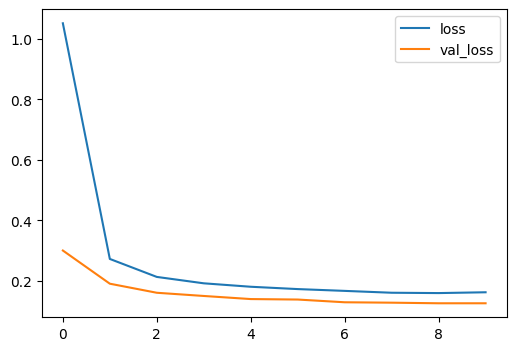

In [68]:
import matplotlib.pyplot as plt

losses = trainer.history['losses']
val_losses = trainer.history['val_losses']
plt.figure(figsize=(6, 4))
plt.plot(range(len(losses)), losses)
plt.plot(range(len(val_losses)), val_losses)
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.show()

In [69]:
losses = trainer.history['losses']
val_losses = trainer.history['val_losses']
acc = trainer.history['train_acc']
val_acc = trainer.history['val_acc']
recall = trainer.history['train_recall']
val_recall = trainer.history['val_recall']
precision = trainer.history['train_precision']
val_precision = trainer.history['val_precision']
f1 = trainer.history['train_f1']
val_f1 = trainer.history['val_f1']

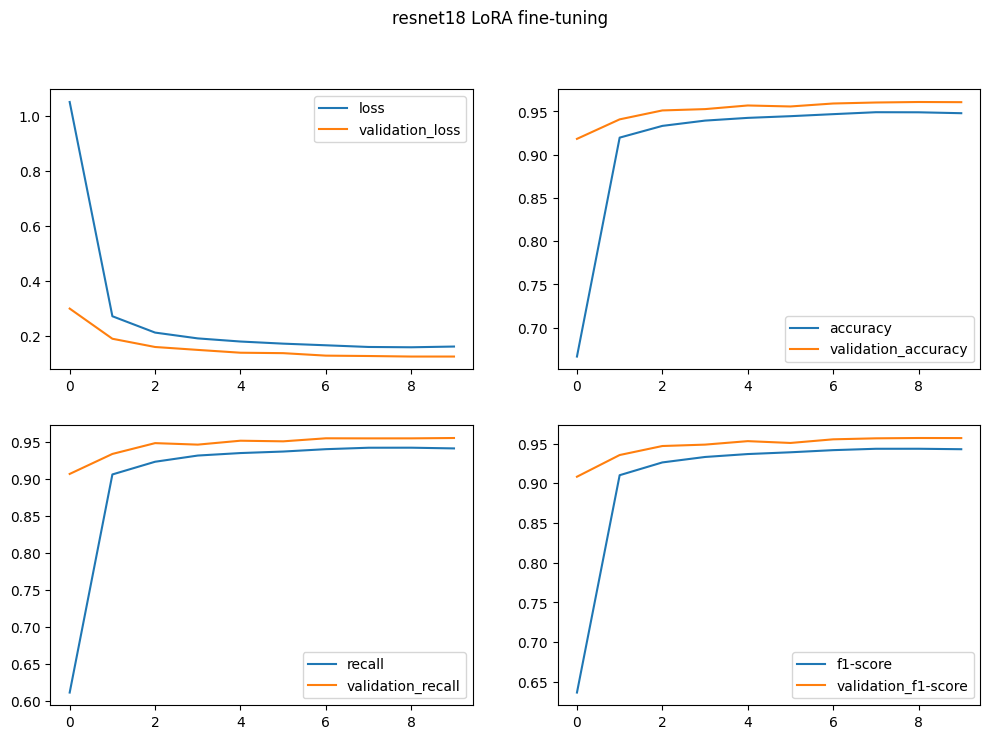

In [70]:
def plot_training_results(trainer, title=None):
    losses = trainer.history['losses']
    val_losses = trainer.history['val_losses']
    acc = trainer.history['train_acc']
    val_acc = trainer.history['val_acc']
    recall = trainer.history['train_recall']
    val_recall = trainer.history['val_recall']
    precision = trainer.history['train_precision']
    val_precision = trainer.history['val_precision']
    f1 = trainer.history['train_f1']
    val_f1 = trainer.history['val_f1']

    plt.figure(figsize=(12, 8))
    for idx, hist in enumerate(
        [
            (losses, val_losses, "loss"),
            (acc, val_acc, "accuracy"),
            (recall, val_recall, "recall"),
            (f1, val_f1, "f1-score")
        ],
        1
    ):
        plt.subplot(2, 2, idx)
        train_metric = hist[0]
        val_metric = hist[1]
        metric = hist[2]
        plt.plot(range(len(train_metric)), train_metric)
        plt.plot(range(len(val_metric)), val_metric)
        plt.legend([f'{metric}', f'validation_{metric}'], loc='best')
    if title:
        plt.suptitle(title)
    plt.show()

plot_training_results(trainer_lora, title="resnet18 LoRA fine-tuning")

## Evaluate the Model

Confusion Matrix:
[[972   8   0   0   0   6   7   5   2   3]
 [  8 300   0   1   1   0   0   1   3   2]
 [  1   1 309   0   0   3   2   0   0   1]
 [  4   0   1 980  10   0   1   2   1   0]
 [  2   0   1  11 379   0   0   2   1   0]
 [  7   0   1   0   0 358  12   2   1   4]
 [  8   0   1   1   0  10 479   1   0   2]
 [  4   2   0   0   1   1   0 555   3   1]
 [  5   2   0   1   0   1   0   0 349   0]
 [  9   0   2   1   0  24   5   2   1 349]]

Classification Report:
              precision    recall  f1-score   support

         dog       0.95      0.97      0.96      1003
         cat       0.96      0.95      0.95       316
    elephant       0.98      0.97      0.98       317
      spider       0.98      0.98      0.98       999
   butterfly       0.97      0.96      0.96       396
         cow       0.89      0.93      0.91       385
       horse       0.95      0.95      0.95       502
     chicken       0.97      0.98      0.98       567
    squirrel       0.97      0.97      0

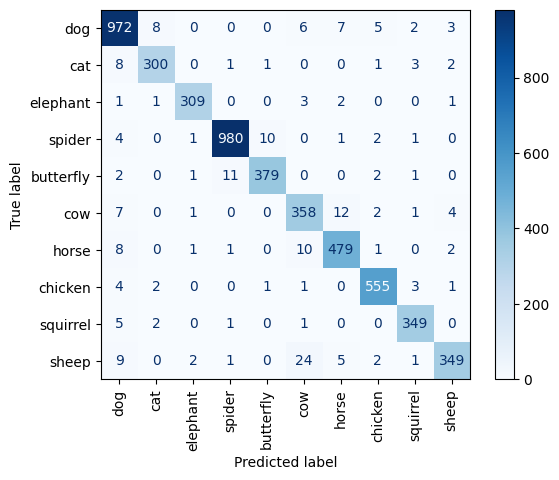

In [102]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_and_report(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Compute classification report
    cr = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(
        true_labels,
        predicted_labels,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        xticks_rotation = 45
    )

    print("\nClassification Report:")
    print(cr)

class_names = os.listdir(data_dir)
evaluate_and_report(model, test_loader, device, class_names)

Confusion Matrix:
[[972   8   0   0   0   6   7   5   2   3]
 [  8 300   0   1   1   0   0   1   3   2]
 [  1   1 309   0   0   3   2   0   0   1]
 [  4   0   1 980  10   0   1   2   1   0]
 [  2   0   1  11 379   0   0   2   1   0]
 [  7   0   1   0   0 358  12   2   1   4]
 [  8   0   1   1   0  10 479   1   0   2]
 [  4   2   0   0   1   1   0 555   3   1]
 [  5   2   0   1   0   1   0   0 349   0]
 [  9   0   2   1   0  24   5   2   1 349]]

Classification Report:
              precision    recall  f1-score   support

         dog       0.95      0.97      0.96      1003
         cat       0.96      0.95      0.95       316
    elephant       0.98      0.97      0.98       317
      spider       0.98      0.98      0.98       999
   butterfly       0.97      0.96      0.96       396
         cow       0.89      0.93      0.91       385
       horse       0.95      0.95      0.95       502
     chicken       0.97      0.98      0.98       567
    squirrel       0.97      0.97      0

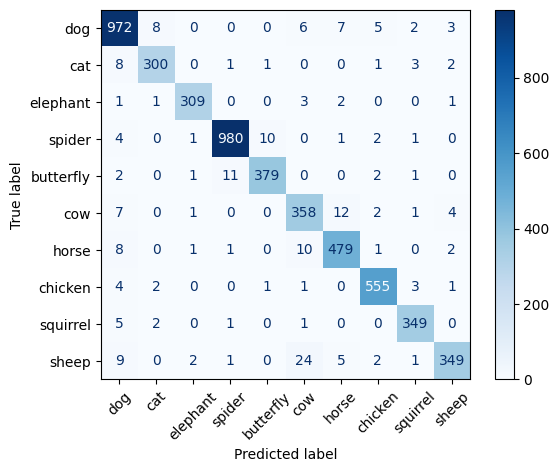

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_and_report(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Compute classification report
    cr = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(
        true_labels,
        predicted_labels,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        xticks_rotation = 45
    )

    print("\nClassification Report:")
    print(cr)

class_names = os.listdir(data_dir)
evaluate_and_report(model, test_loader, device, class_names)

## Sample Prediction

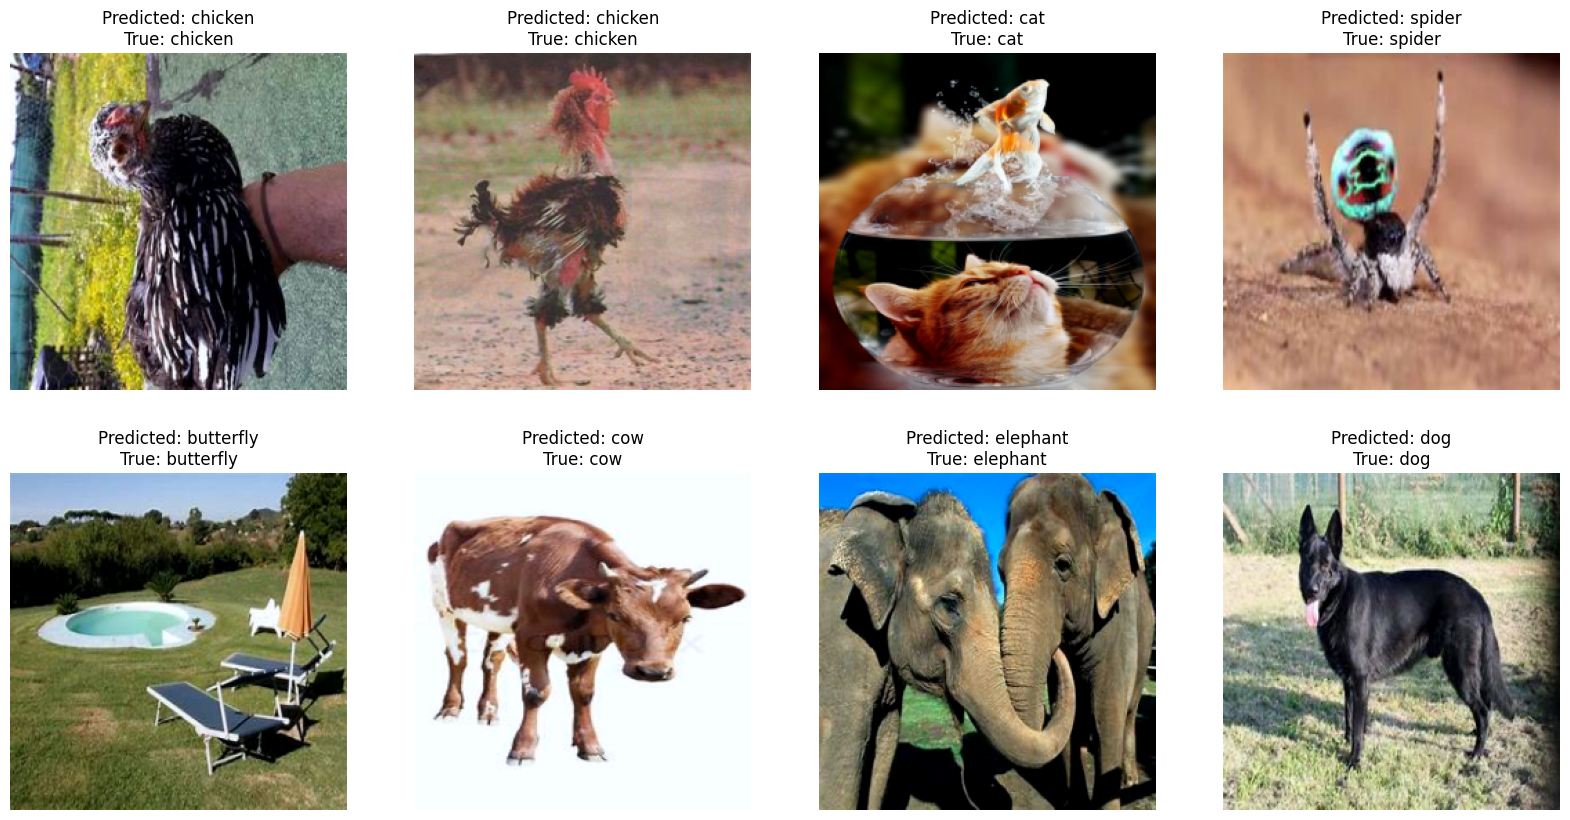

In [71]:
def plot_predictions(model, test_loader, class_names, device):
    model.eval()
    images_so_far = 0
    num_images = 8

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                if images_so_far >= num_images:
                    return

                ax = axes[images_so_far // 4, images_so_far % 4]
                ax.axis('off')
                # revert back the pixel
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                # img = img * 0.5 + 0.5  # unnormalize
                # from: https://discuss.pytorch.org/t/what-is-the-most-simple-way-to-reobtain-a-pil-image-after-normalization/85355
                mean = np.array([0.4451, 0.4262, 0.3959])  # mean of your dataset
                std = np.array([0.2411, 0.2403, 0.2466])  # std of your dataset
                img = std * img + mean
                img = np.clip(img, 0, 1)
                # pil_image = Image.fromarray(img)

                ax.imshow(img)
                ax.set_title(f"Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}")
                images_so_far += 1

# Assuming your test_loader is already defined and you have the model, class_names, and device set up
class_names = os.listdir(data_dir)
test_visualize_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
plot_predictions(model, test_visualize_loader, class_names, device)

## Training without LoRA

### Training

In [73]:
model_no_lora = models.resnet18(weights="IMAGENET1K_V1")
model_no_lora.fc = nn.Linear(model_no_lora.fc.in_features, 10)

trainer_no_lora = get_trainer(model_no_lora, use_lora = False)

Trainer and Model initialized. LoRA is not used
trainable params: 11181642 || all params: 11181642 || trainable%: 100.0


In [74]:
from datetime import datetime

epochs = 10
stime = datetime.now()
trainer_no_lora.fit(train_loader, test_loader, epochs, verbose=1, patience=5)
etime = datetime.now()

seconds = (etime - stime).total_seconds()
# print(f"Training time: {seconds//60} minutes, {seconds%60} seconds | {seconds} total seconds")
print(f"Training time: {seconds//60} minutes, {seconds%60} seconds")

Training	 | Epoch 1/10 | Loss: 0.3145: 100%|██████████| 655/655 [03:02<00:00,  3.60it/s, train_accuracy=0.901, train_f1=0.892, train_precision=0.894, train_recall=0.889]
Validation	 | Epoch 1/10 | Loss: 0.2390: 100%|██████████| 164/164 [00:28<00:00,  5.70it/s, val_accuracy=0.928, val_f1=0.919, val_precision=0.916, val_recall=0.926]
Training	 | Epoch 2/10 | Loss: 0.1478: 100%|██████████| 655/655 [02:59<00:00,  3.65it/s, train_accuracy=0.954, train_f1=0.949, train_precision=0.949, train_recall=0.948]
Validation	 | Epoch 2/10 | Loss: 0.2433: 100%|██████████| 164/164 [00:28<00:00,  5.73it/s, val_accuracy=0.924, val_f1=0.917, val_precision=0.922, val_recall=0.913]
Training	 | Epoch 3/10 | Loss: 0.1009: 100%|██████████| 655/655 [03:02<00:00,  3.59it/s, train_accuracy=0.968, train_f1=0.965, train_precision=0.966, train_recall=0.965]
Validation	 | Epoch 3/10 | Loss: 0.3133: 100%|██████████| 164/164 [00:28<00:00,  5.67it/s, val_accuracy=0.905, val_f1=0.9, val_precision=0.906, val_recall=0.9]
Tr


best loss: 0.23903790717126755
Training time: 21.0 minutes, 1.4683509999999842 seconds


### Plot the Training Results

In [ ]:
import matplotlib.pyplot as plt

losses = trainer_no_lora.history['losses']
val_losses = trainer_no_lora.history['val_losses']
plt.figure(figsize=(6, 4))
plt.plot(range(len(losses)), losses)
plt.plot(range(len(val_losses)), val_losses)
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.show()

In [75]:
def plot_training_results(trainer, title=None):
    losses = trainer.history['losses']
    val_losses = trainer.history['val_losses']
    acc = trainer.history['train_acc']
    val_acc = trainer.history['val_acc']
    recall = trainer.history['train_recall']
    val_recall = trainer.history['val_recall']
    precision = trainer.history['train_precision']
    val_precision = trainer.history['val_precision']
    f1 = trainer.history['train_f1']
    val_f1 = trainer.history['val_f1']

    plt.figure(figsize=(12, 8))
    for idx, hist in enumerate(
        [
            (losses, val_losses, "loss"),
            (acc, val_acc, "accuracy"),
            (recall, val_recall, "recall"),
            (f1, val_f1, "f1-score")
        ],
        1
    ):
        plt.subplot(2, 2, idx)
        train_metric = hist[0]
        val_metric = hist[1]
        metric = hist[2]
        plt.plot(range(len(train_metric)), train_metric)
        plt.plot(range(len(val_metric)), val_metric)
        plt.legend([f'{metric}', f'validation_{metric}'], loc='best')
    if title:
        plt.suptitle(title)
    plt.show()

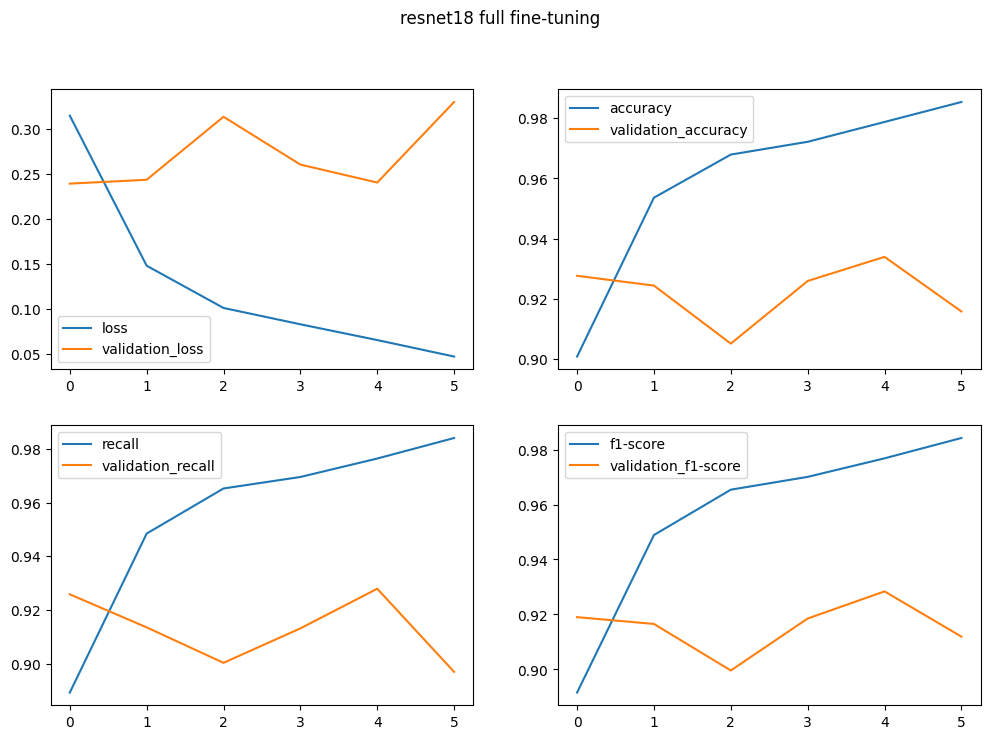

In [76]:
plot_training_results(trainer_no_lora, title="resnet18 full fine-tuning")

### Evaluate the Model

Confusion Matrix:
[[975   1   0   3   0   4   6   7   4   3]
 [ 29 267   0   7   2   2   0   1   7   1]
 [ 19   1 271   9   0   6   6   1   2   2]
 [ 19   0   0 964   6   0   0   2   6   2]
 [  3   0   0  34 350   2   2   1   4   0]
 [ 14   0   1   2   0 354   4   2   0   8]
 [ 37   1   0   1   0  17 436   4   0   6]
 [ 13   0   0  13   0   4   2 533   1   1]
 [ 18   3   0  10   2   3   0   5 317   0]
 [ 24   1   2   5   0  17   8   4   4 328]]

Classification Report:
              precision    recall  f1-score   support

         dog       0.85      0.97      0.91      1003
         cat       0.97      0.84      0.91       316
    elephant       0.99      0.85      0.92       317
      spider       0.92      0.96      0.94       999
   butterfly       0.97      0.88      0.93       396
         cow       0.87      0.92      0.89       385
       horse       0.94      0.87      0.90       502
     chicken       0.95      0.94      0.95       567
    squirrel       0.92      0.89      0

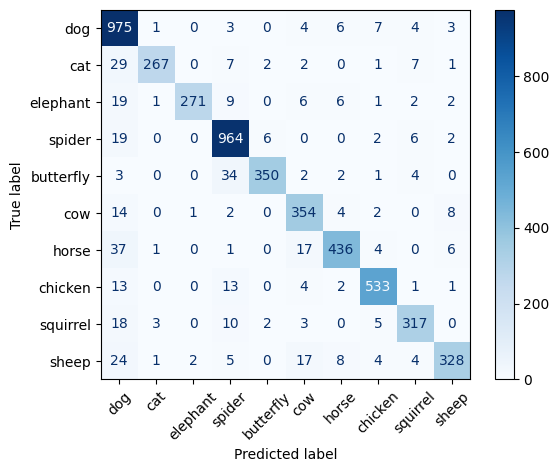

In [104]:
class_names = os.listdir(data_dir)
evaluate_and_report(model_no_lora, test_loader, device, class_names)

### Sample Prediction

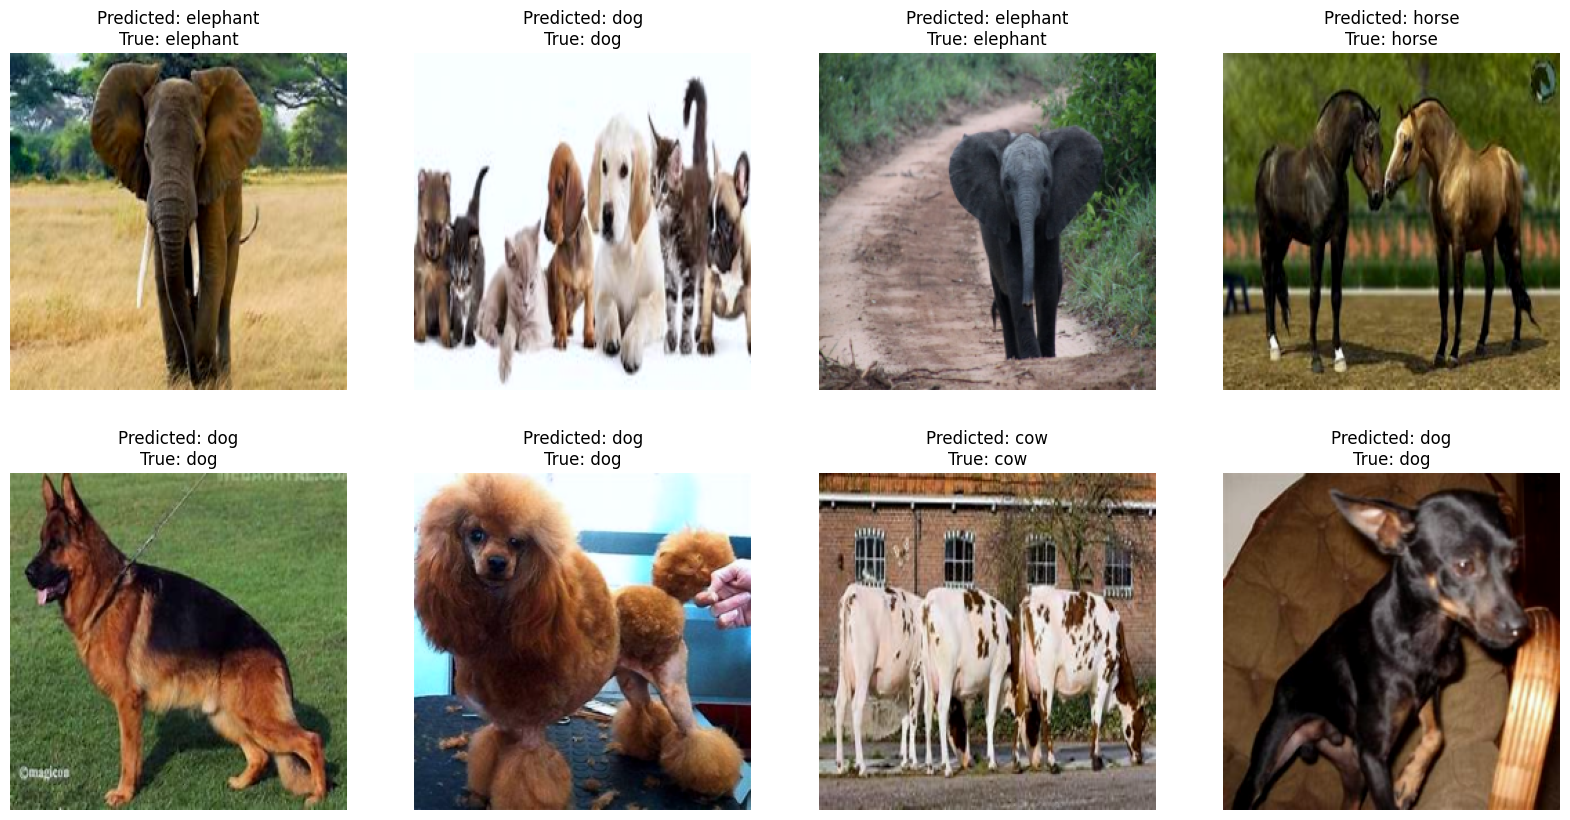

In [78]:
test_visualize_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
plot_predictions(model_no_lora, test_visualize_loader, class_names, device)

## LoRA vs. Full fine-tuning Comparison

### Training Progress Plots

In [86]:
# LoRA
losses = trainer.history['losses']
val_losses = trainer.history['val_losses']
acc = trainer.history['train_acc']
val_acc = trainer.history['val_acc']
recall = trainer.history['train_recall']
val_recall = trainer.history['val_recall']
precision = trainer.history['train_precision']
val_precision = trainer.history['val_precision']
f1 = trainer.history['train_f1']
val_f1 = trainer.history['val_f1']

# Full fine-tuning
losses_no_lora = trainer_no_lora.history['losses']
val_losses_no_lora = trainer_no_lora.history['val_losses']
acc_no_lora = trainer_no_lora.history['train_acc']
val_acc_no_lora = trainer_no_lora.history['val_acc']
recall_no_lora = trainer_no_lora.history['train_recall']
val_recall_no_lora = trainer_no_lora.history['val_recall']
precision_no_lora = trainer_no_lora.history['train_precision']
val_precision_no_lora = trainer_no_lora.history['val_precision']
f1_no_lora = trainer_no_lora.history['train_f1']
val_f1_no_lora = trainer_no_lora.history['val_f1']

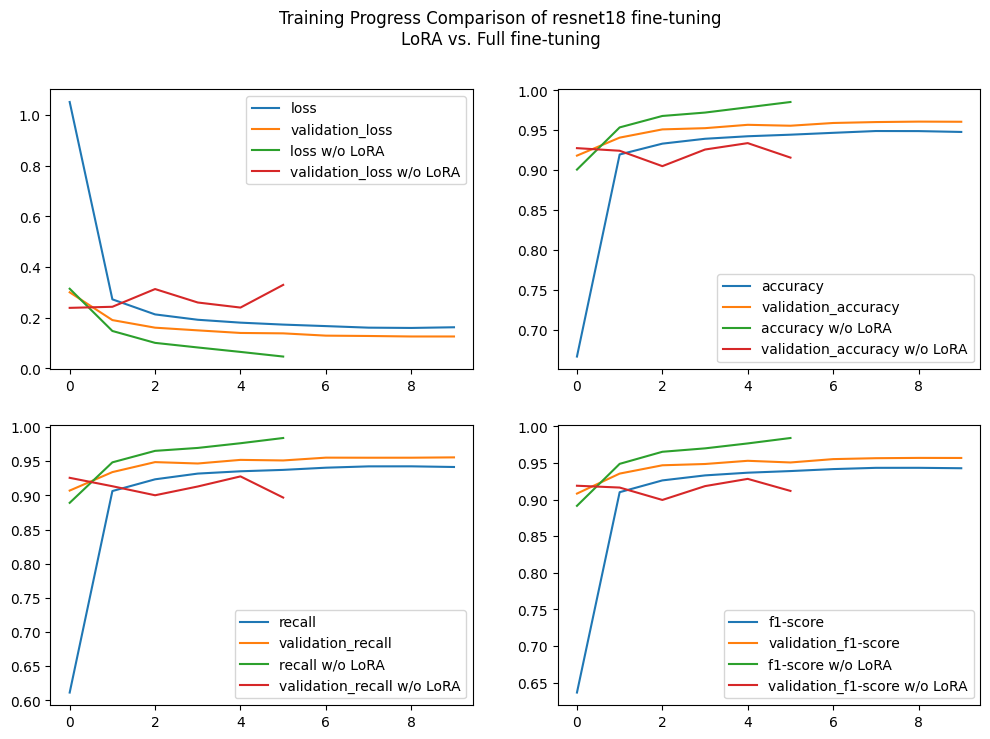

In [87]:
plt.figure(figsize=(12, 8))
for idx, (hist, hist_no_lora) in enumerate(
    zip(
        [(losses, val_losses, "loss"), (acc, val_acc, "accuracy"), (recall, val_recall, "recall"), (f1, val_f1, "f1-score")],
        [(losses_no_lora, val_losses_no_lora, "loss w/o LoRA"), (acc_no_lora, val_acc_no_lora, "accuracy w/o LoRA"), (recall_no_lora, val_recall_no_lora, "recall w/o LoRA"), (f1_no_lora, val_f1_no_lora, "f1-score w/o LoRA")],
    ),
    1
):
    plt.subplot(2, 2, idx)
    train_metric = hist[0]
    val_metric = hist[1]
    metric = hist[2]
    plt.plot(range(len(train_metric)), train_metric)
    plt.plot(range(len(val_metric)), val_metric)

    train_metric_no_lora = hist_no_lora[0]
    val_metric_no_lora = hist_no_lora[1]
    metric_no_lora = hist_no_lora[2]
    plt.plot(range(len(train_metric_no_lora)), train_metric_no_lora)
    plt.plot(range(len(val_metric_no_lora)), val_metric_no_lora)

    plt.legend([f'{metric}', f'validation_{metric}', f'{metric_no_lora}', f'validation_{metric_no_lora}'], loc='best')

plt.suptitle("Training Progress Comparison of resnet18 fine-tuning\nLoRA vs. Full fine-tuning")
plt.show()

### Time Calculation Report

Full fine-tuning training is stopped at 6 epochs due to 'patience' parameter. Hence I consider the epoch in calculation.

- resnet18's LoRA fine-tuning
  - Training + Validation time: 30.0 minutes, 12.544785999999931 seconds | 10 epochs
  - total_seconds: 30*60 + 12.544785999999931 = 1812.544786 seconds
  - seconds_per_epoch = 1812.544786 / 10 = 181.2544786 (including validation epoch)
  - training epoch: (02:25 + 02:51 + 02:43 + 02:22 + 02:21 + 02:19 + 02:43 + 02:19 + 02:20 + 02:33)/10 = 1496/10 = 149,6 seconds per epoch in average
  - validation epoch: (00:30 + 00:45 + 00:31 + 00:29 + 00:29 + 00:28 + 00:28 + 00:29 + 00:29 + 00:30)/10 = 308/10 = 30,8 seconds per epoch in average

- resnet18's full fine-tuning
  - Training + Validation  time: 21.0 minutes, 1.4683509999999842 seconds | 6 epochs
  - total_seconds: 21*60 + 1.4683509999999842 = 1261.468351 seconds
  - seconds_per_epoch = 1261.468351 / 6 = 210.24472516666665 (including validation epoch)
  - training epoch: (03:02 + 02:59 + 03:02 + 03:02 + 03:00 + 02:59)/6 = 1084/6 = 180,666... seconds per epoch in average
  - validation epoch: (00:28 + 00:28 + 00:28 + 00:29 + 00:29 + 00:29)/6 = 28,5 seconds per epoch in average

### Final Table

| resnet18 | training time per epoch | validation time per epoch | test accuracy | test precision | test recall | test f1-score |
| -- | -- | -- | -- | -- | -- | -- |
| LoRA | 149,6 seconds | 30,8 seconds | 0,96 | 0,96 | 0,96 | 0,96 |
| Full fine-tuning | 180,666... seconds | 28,5 seconds | 0,92 | 0,93 | 0,90 | 0,91 |